In [99]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import concat
import pandas_datareader as data
import seaborn as sns
import matplotlib.dates as mdates

from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
import tensorflow

In [100]:
#creating a start date and end date
start = '2010-01-01'
end =  datetime.today().strftime("%Y-%m-%d")
#end = '2019-12-31'

company = 'AAPL'
#creating the dataframe
df= data.DataReader(company, 'yahoo', start, end)

#getting the first 5 rows and the last 5 rows
print(df.head(5))
print(df.tail(5))

df.shape

                High       Low      Open     Close       Volume  Adj Close
Date                                                                      
2010-01-04  7.660714  7.585000  7.622500  7.643214  493729600.0   6.515213
2010-01-05  7.699643  7.616071  7.664286  7.656429  601904800.0   6.526476
2010-01-06  7.686786  7.526786  7.656429  7.534643  552160000.0   6.422665
2010-01-07  7.571429  7.466071  7.562500  7.520714  477131200.0   6.410791
2010-01-08  7.571429  7.466429  7.510714  7.570714  447610800.0   6.453411
                  High         Low        Open       Close      Volume  \
Date                                                                     
2022-12-02  148.000000  145.649994  145.960007  147.809998  65421400.0   
2022-12-05  150.919998  145.770004  147.770004  146.630005  68826400.0   
2022-12-06  147.300003  141.919998  147.070007  142.910004  64727200.0   
2022-12-07  143.369995  140.000000  142.190002  140.940002  69721100.0   
2022-12-08  143.520004  141.100

(3257, 6)

In [101]:
#dropping the adj close column as it is not needed since it similar to the close column and also the date column
#df = df.reset_index()
df.head()
#df = df.drop(['Date','Adj Close'], axis=1)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,7.660714,7.585000,7.622500,7.643214,493729600.0,6.515213
2010-01-05,7.699643,7.616071,7.664286,7.656429,601904800.0,6.526476
2010-01-06,7.686786,7.526786,7.656429,7.534643,552160000.0,6.422665
2010-01-07,7.571429,7.466071,7.562500,7.520714,477131200.0,6.410791
2010-01-08,7.571429,7.466429,7.510714,7.570714,447610800.0,6.453411


In [102]:
#checking if there are any missing datas
missing_data = df[df.isna().any(axis=1)]
print(missing_data)
df.info()
print(df.shape)

Empty DataFrame
Columns: [High, Low, Open, Close, Volume, Adj Close]
Index: []
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3257 entries, 2010-01-04 to 2022-12-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       3257 non-null   float64
 1   Low        3257 non-null   float64
 2   Open       3257 non-null   float64
 3   Close      3257 non-null   float64
 4   Volume     3257 non-null   float64
 5   Adj Close  3257 non-null   float64
dtypes: float64(6)
memory usage: 178.1 KB
(3257, 6)


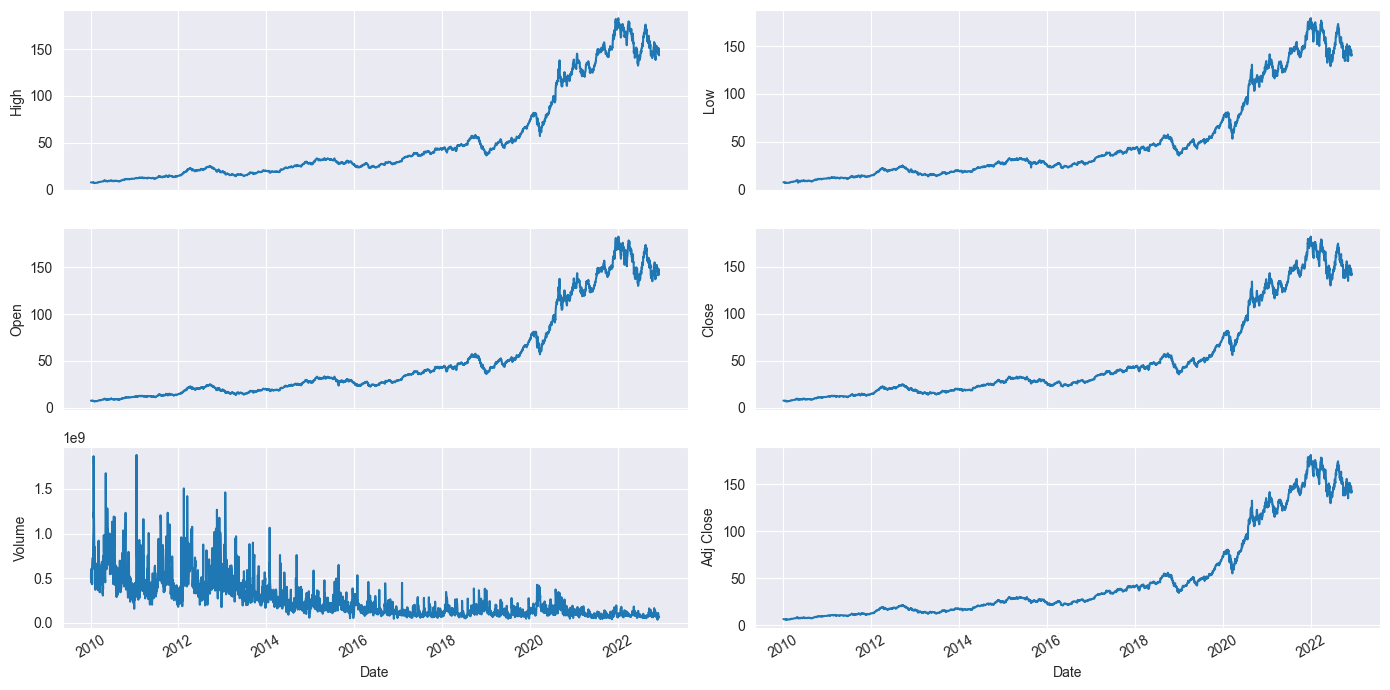

In [103]:
#Plot line charts
df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        #ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [104]:
#splitting the data into training and testing
train_header = pd.DataFrame(df['Close'][0:int(len(df)*0.70)])
target_header = pd.DataFrame(df['Close'][int(len(df)*0.70):int(len(df))])
print(df.shape)
print(train_header.shape)
print(target_header.shape)

(3257, 6)
(2279, 1)
(978, 1)


In [105]:
#Scaling the stock data so that they fit inbetween 0 and 1
from sklearn.preprocessing import MinMaxScaler
from numpy import set_printoptions
scaler = MinMaxScaler(feature_range=(0,1))
train_header_array = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

train_header_array


array([[0.00447776],
       [0.00455321],
       [0.00385789],
       ...,
       [0.77676418],
       [0.76551674],
       [0.7752797 ]])

In [106]:
#define how many days in the past we will look into
#the closing price of the particular day would depend on the previous days
historical_data = 50

#########################
# PREPARING TRAINING DATA
#########################
x_train = []
y_train = []

for x in range(historical_data, train_header_array.shape[0]):
    x_train.append(train_header_array[x - historical_data:x, 0])
    y_train.append((train_header_array[x, 0])) #because we are considering only one column

# turning x and y train into numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)


In [107]:
# now we are going to reshape the x_train so that it works with the neural network
# the 1 indicates one additional dimension
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [108]:
##################
# INSTANTIATE THE MODEL
##################
model = Sequential()

# now we can specify the layers - always add 1 LSTM layer and then a Dropout layer rinse/repeat the final layer is
# the Dense layer that is going to be just one unit, and it's going to the stock price prediction

model.add(LSTM(units=50, activation = 'relu', return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units =60, activation = 'relu', return_sequences = True,))
model.add(Dropout(0.3))
model.add(LSTM(units =80, activation = 'relu', return_sequences = True, ))
model.add(Dropout(0.4))
model.add(LSTM(units =120, activation = 'relu'))
model.add(Dropout(0.5))
# prediction of the next closing price
model.add(Dense(units = 1))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 50, 50)            10400     
                                                                 
 dropout_16 (Dropout)        (None, 50, 50)            0         
                                                                 
 lstm_17 (LSTM)              (None, 50, 60)            26640     
                                                                 
 dropout_17 (Dropout)        (None, 50, 60)            0         
                                                                 
 lstm_18 (LSTM)              (None, 50, 80)            45120     
                                                                 
 dropout_18 (Dropout)        (None, 50, 80)            0         
                                                                 
 lstm_19 (LSTM)              (None, 120)              

Epoch 1/25
101/101 [==============================] - 29s 120ms/step - loss: 0.0197 - mae: 0.0830
Epoch 2/25
101/101 [==============================] - 12s 123ms/step - loss: 0.0047 - mae: 0.0407
Epoch 3/25
101/101 [==============================] - 13s 129ms/step - loss: 0.0053 - mae: 0.0434
Epoch 4/25
101/101 [==============================] - 13s 127ms/step - loss: 0.0046 - mae: 0.0402
Epoch 5/25
101/101 [==============================] - 13s 123ms/step - loss: 0.0043 - mae: 0.0401
Epoch 6/25
101/101 [==============================] - 12s 123ms/step - loss: 0.0037 - mae: 0.0375
Epoch 7/25
101/101 [==============================] - 12s 119ms/step - loss: 0.0042 - mae: 0.0392
Epoch 8/25
101/101 [==============================] - 14s 138ms/step - loss: 0.0036 - mae: 0.0370
Epoch 9/25
101/101 [==============================] - 12s 122ms/step - loss: 0.0039 - mae: 0.0375
Epoch 10/25
101/101 [==============================] - 12s 123ms/step - loss: 0.0034 - mae: 0.0348
Epoch 11/25
101/101

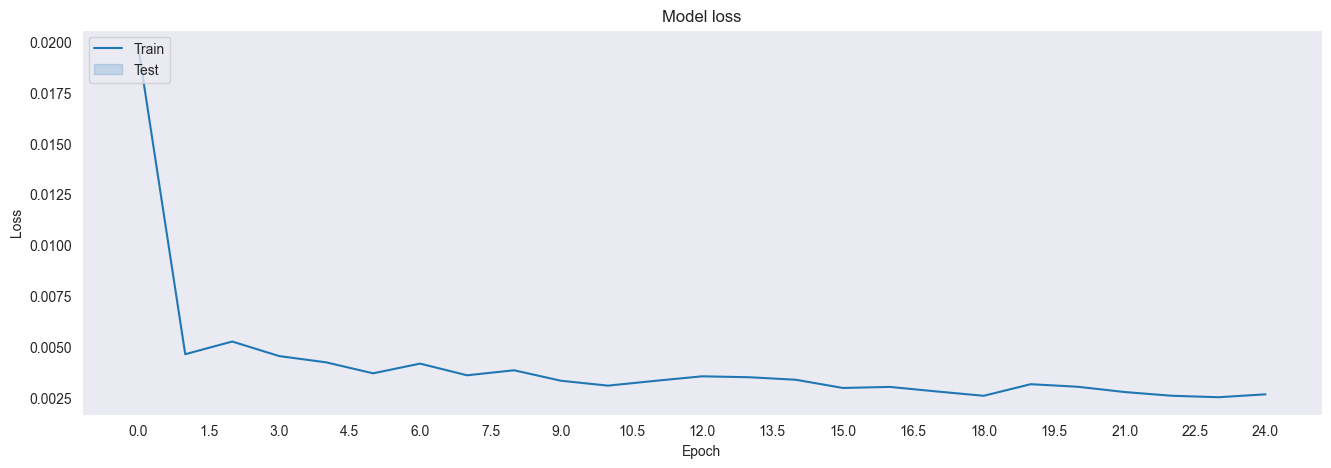

In [109]:
model.compile(optimizer='adam', loss='mean_squared_error',metrics = ['mae'])
epochs = 25
history=model.fit(x_train, y_train, epochs=epochs)


# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

SAVE THE MODEL SO IT WOULD BE USEFUL IN STREAMLIT

In [110]:

model.save('new_lstm_model.h5')

In [111]:
# LOAD THE DATA - it has to be data the model has not seen before
# this is the time range of the data - we have the data but the model has never seen that data
# so this is a perfect way to see how well it performs
_start = '2010-01-01'
_end = datetime.today().strftime("%Y-%m-%d")
_data = data.DataReader(company,  'yahoo', _start, _end)

In [112]:
#getting the actual prices
# we need to scale prices, we need to concatenate the full data set that we want to predict on
# this is NOT the predicted price, but the real price from the market
actual_prices = _data['Close'].values

In [113]:
# this will combine the training data and the test data
total_dataset = pd.concat((df['Close'], _data['Close']), axis=0)


In [114]:
# this is what our model is going to see as an input, so it can predict
model_inputs = total_dataset[len(total_dataset) - len(_data) - historical_data:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)


MAKE PREDICTIONS ON TEST DATA

In [115]:
###############################
# MAKE PREDICTIONS ON TEST DATA
###############################

# we don't use the y_test because we already have the stock prices
x_test = []
y_test = []
# if you remove the + 1 it will remove the newest data
for x in range(historical_data, len(model_inputs)):
    x_test.append(model_inputs[x - historical_data:x, 0])
    y_test.append(model_inputs[i, 0])

x_test,y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))



102/102 [==============================] - 12s 41ms/step


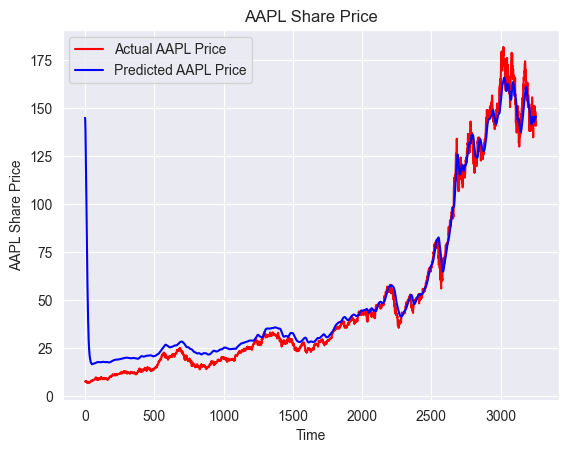

In [116]:
# now let's predict on the x_test data,the predicted prices are now going to be scaled, so we need to reverse scale them or rather inverse_transform them
y_pred = model.predict(x_test)
# now we are back to the actual predicted price, non-scaled
y_pred = scaler.inverse_transform(y_pred)

# now let plot the predictions instead of just numbers. CHARTS BABY
plt.plot(actual_prices, color="red", label=f"Actual {company} Price")
plt.plot(y_pred, color="blue", label=f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{company} Share Price")
plt.legend()
# you can also do .pdf for a vector like file (super zoomy)
plt.savefig('Prediction_test.svg')
# this acts as a 'end conn' situation
plt.show()

EVALUATING THE MODEL PERFORMANCES

In [120]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,accuracy_score
#evaluate the model
mae = mean_absolute_error(actual_prices, y_pred)
mse = mean_squared_error(actual_prices, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(actual_prices, y_pred)



#printing the model evaluation values
print('mae:  {:.2f}'.format(mae))
print('mse:  {:.2f}'.format(mse))
print('Root mean square error:  {:.2f}'.format(rmse))
print('R2 score: ', r2)



mae:  5.26
mse:  92.45
Root mean square error:  9.62
R2 score:  0.9583503381789276


Making Predictions for Next day

In [118]:
#########################
# PREDICTING OUR NEXT DAY
#########################

final_data = [model_inputs[len(model_inputs) + 1 - historical_data:len(model_inputs + 1), 0]]
final_data = np.array(final_data)
final_data = np.reshape(final_data, (final_data.shape[0], final_data.shape[1], 1))

print(scaler.inverse_transform(final_data[-1]))

Next_day = model.predict(final_data)
Next_day  = scaler.inverse_transform(Next_day)
print(f' Price Prediction for tomorrow would be: {Next_day}')

[[138.19999695]
 [142.44999695]
 [146.1000061 ]
 [146.3999939 ]
 [145.42999268]
 [140.08999634]
 [140.41999817]
 [138.97999573]
 [138.33999634]
 [142.99000549]
 [138.38000488]
 [142.41000366]
 [143.75      ]
 [143.86000061]
 [143.38999939]
 [147.27000427]
 [149.44999695]
 [152.33999634]
 [149.3500061 ]
 [144.80000305]
 [155.74000549]
 [153.33999634]
 [150.6499939 ]
 [145.02999878]
 [138.88000488]
 [138.38000488]
 [138.91999817]
 [139.5       ]
 [134.86999512]
 [146.86999512]
 [149.69999695]
 [148.27999878]
 [150.03999329]
 [148.78999329]
 [150.72000122]
 [151.28999329]
 [148.00999451]
 [150.17999268]
 [151.07000732]
 [148.11000061]
 [144.22000122]
 [141.16999817]
 [148.02999878]
 [148.30999756]
 [147.80999756]
 [146.63000488]
 [142.91000366]
 [140.94000244]
 [142.6499939 ]]
1/1 [==============================] - 8s 8s/step
 Price Prediction for tomorrow would be: [[145.06195]]
